### MBD-EN OCT20 - IE School of Human Scienses & Technology

# Statistical Programming in Python

### Group Assignment - Bike Sharing Prediction

Authors: Group D - **Kathleen Hess, Raquel Cabero, Ignacio Martinez, Pedro Santos, Isagani Trinidad, Julian Scholz**

Date: 06/03/2021

# Summary

The goal of this assignment is to **Predict the total number of Washington D.C. bicycle users on an hourly basis** using a dataset ("hour.csv") with data from 2011 and 2012. The notebook is divided in the following steps:

### Part 1: Exploratory Data Analysis

1.1. Ensuring data quality

1.2. Plotting clear and meaningful figures

1.3. Checking possibly redundant variables via correlations

1.4. Giving insights on what seems relevant for prediction and what does not

### Part 2: Data Engineering

2.1. Discussion on missing values and outliers

2.2. Treatment of text and date features

2.3. Generation of extra features and studying the influence of combinations of features

2.4. Giving new insights on what seems relevant for prediction and what does not

2.5. Use of scikit-learn pipelines to perform transformations
   
### Part 3: Machine Learning 

3.1. Choosing sensible models (linear and non-linear)

a) Baseline Linear Regression with Initial Variables

b) Linear Regression with New Variables

c) Baseline Random Forest

3.2. Tuning model parameters with validation

3.3. Obtaining accurate predictions in test

3.4. Plotting predictions vs reality for additional insights


------

# Bike Sharing Prediction

## Part 1: Exploratory Data Analysis

We will first conduct the Exploratory Data Analysis or (EDA) to understand the dataset, by summarizing its main characteristics.

#### Loading packages and importing the required libraries:

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import ipywidgets as ipw
import sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, MinMaxScaler
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error , r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import set_config
set_config(display="diagram")

def outlier(col, n):
    IQR = col.quantile(.75) - col.quantile(.25)
    upper = col.quantile(.75) + (n*IQR)
    lower = col.quantile(.25) - (n*IQR)
    print("Percent Outliers:", "{:.2%}".format( ( len(df[col > upper]) + len(df[col < lower]) ) / len(df) ) )
    print("Percent Low Outliers:", "{:.2%}".format( len(df[col < lower]) / len(df) ) )
    print("Percent High Outliers:", "{:.2%}".format( len(df[col > upper]) / len(df) ) )
    return lower, upper

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate(test_features, test_labels):
    print('Root Mean Squared Error: %.2f'% mean_squared_error(test_features, test_labels,squared = False))
    print('Coefficient of determination: %.2f'%r2_score(test_features, test_labels))
    print('MAPE: %.2f'%  mean_absolute_percentage_error(test_features, test_labels))

#### Loading the data into the pandas data frame:

The variable "instant" could be our index since since it is a good key column (identifying each observation with a different value for every row from 1 to 17379).

In [2]:
df = pd.read_csv("hour.csv",index_col="instant",parse_dates = ["dteday"])

**Column Legend:**
* **instant:** records index
* **dteday:** date
* **hr:** hour (0 to 23)
* **weathersit:** Weather situation
* **temp:** Normalized temperature in Celsius. The values are divided to 41 (max)
* **atemp:** Normalized feeling temperature in Celsius. The values are divided to 50 (max)
* **hum:** Normalized humidity. The values are divided to 100 (max)
* **windspeed:** Normalized wind speed. The values are divided to 67 (max)
* **casual:** count of casual users
* **registered:** count of registered users
* **cnt:** count of total rental bikes including both casual and registered

### 1.1. Ensuring data quality

We will take a look of the first rows of our data, to see what it looks like by displaying the top 5 rows.

In [3]:
df.head(5)

,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,
1,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,2,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,3,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,4,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,0,1,1


Looking at the data type of each column and other informations by using info() method which prints information about a DataFrame including the index dtype and columns, non-null values and memory usage.

There are a total of 17379 rows in the dataset and 10 different variables (columns).

Variable Types: 
    
- Datetime: dteday (datetime64[ns])

- Integer: hr (int64), casual (int64), registered (int64) and cnt (int64)

- Float: temp (float64), atemp (float64), hum (float64), windspeed (float64)
    
- Object: weathersit (object)
  
There are missing/null values in variables weathersit, temp, atemp, hum and windspeed

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17379 entries, 1 to 17379
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   dteday      17379 non-null  datetime64[ns]
 1   hr          17379 non-null  int64         
 2   weathersit  17279 non-null  object        
 3   temp        17280 non-null  float64       
 4   atemp       17279 non-null  float64       
 5   hum         17279 non-null  float64       
 6   windspeed   17279 non-null  float64       
 7   casual      17379 non-null  int64         
 8   registered  17379 non-null  int64         
 9   cnt         17379 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(4), object(1)
memory usage: 1.5+ MB
None


Below we looked for duplicate rows containing duplicate data, but we notice that in this dataset we don't have any duplicates.

In [5]:
duplicate_rows_df = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape)

number of duplicate rows:  (0, 10)


### 1.2. Plotting clear and meaningful figures

We start this section by creating 3 lists to separate the numerical columns from the categorical colums:
   - all_cols: all 11 columns ['dteday','hr','weathersit','temp','atemp','hum','windspeed','casual','registered','cnt']
   - num_cols: 9 numeric columns ['hr', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
   - cat_cols: 2 categorical columns ['dteday', 'weathersit']
   
These lists will be used in the Exploratory Data Analysis since distinct types of analyses are relevant for numerical and categorical variables.

In [6]:
all_cols = df.columns.values.tolist()
num_cols = df.select_dtypes(include=np.number).columns.to_list()
cat_cols = df.select_dtypes(exclude = np.number).columns.to_list()
all_cols = df.columns.values.tolist()
num_cols = df.select_dtypes(include=np.number).columns.to_list()
cat_cols = df.select_dtypes(exclude = np.number).columns.to_list()

**Numerical Columns Analysis**

Below with the describe() method we have a look at the descriptive statistics of the numerical columns including those that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values.

In [7]:
print(df.describe())

                 hr          temp         atemp           hum     windspeed  \
count  17379.000000  17280.000000  17279.000000  17279.000000  17279.000000   
mean      11.546752      0.497071      0.475530      0.627235      0.190114   
std        6.914405      0.192474      0.171782      0.193047      0.122378   
min        0.000000      0.020000      0.000000      0.000000      0.000000   
25%        6.000000      0.340000      0.333300      0.480000      0.104500   
50%       12.000000      0.500000      0.484800      0.630000      0.194000   
75%       18.000000      0.660000      0.621200      0.780000      0.253700   
max       23.000000      1.000000      1.000000      1.000000      0.850700   

             casual    registered           cnt  
count  17379.000000  17379.000000  17379.000000  
mean      35.676218    153.786869    189.463088  
std       49.305030    151.357286    181.387599  
min        0.000000      0.000000      1.000000  
25%        4.000000     34.000000     

A great way to have a better understanding of the data is by plotting it visually. We will use ipywidgets, also known as jupyter-widgets or simply widgets, which are interactive HTML widgets for Jupyter notebooks. 

In the below distribution plot (histogram) we can iteratively select the numerical column we want to see the distribution. 

#### Describing the distribution of the numerical columns:

Thanks to the "ipw interact" function, we can observe the distribution by variable on the same plot.

* **hr**: ias expected the hour shows a uniform distribution. 

* **temp**: most of our values are distributed around 0.2 and 0.8, having very little amount of data with very high or very low temperatures.

* **windspeed**: right skewed distribution with most of the values in between 0 and 0.3, which means we don't have much data with very high windspeed values.

* **casual**: right skewed distribution. Most of the values for casual users are in between 10 and 50. It is very unusual in our dataset to have more than 150 casual users per hour.

* **registered**: also right skewed distributed. Most of the values are in between 20 and 300 more or less. There might be a point that we have more than 800 registered users renting the bike per hour but that would be really rare. 

* **cnt**: our target variable being calculated from the sum of the previous 2 variables is also right skewed distributed.

In [8]:
@ipw.interact(Column = ipw.Dropdown(options = num_cols), bin = ipw.IntSlider(value = 10))
def plot_hist(Column, bin):
  sns.distplot(a = df[Column], kde=True, bins = bin)
  return df[Column].value_counts(bins = bin)

interactive(children=(Dropdown(description='Column', options=('hr', 'temp', 'atemp', 'hum', 'windspeed', 'casu…

**Categorical Columns Analysis**

In the below dropdown menu we can see the distribution of the categorical columns.

***dteday - Date column:***
        
 - We see the maximum count is 24 (corresponding to the different 24h hours) for several days, meaning in that days bikes were used in every hour. 
 - On 29/10/2012 only in 1 hour bikes were used (we checked it was at hour 0 - midnight). We found the below news which explains:
  
29/10/2012 - 11:31 NEW YORK (Reuters) - Hurricane Sandy, the monster storm bearing down on the U.S. East Coast, strengthened on Monday after hundreds of thousands moved to higher ground, public transport shut down and the U.S. stock market suffered its first weather-related closure in 27 years.

***weathersit - Weather situation column:***

 - 4 different weather situation categories
 - 66% of the hours the weather was "Clear, Few clouds, Partly cloudy, Partly cloudy"
 - 26% of the hours the weather was "Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist"
 - So only around 8% of the hours the weather did not seem good for bike rides.

In [9]:
@ipw.interact(Column = ipw.Dropdown(options = cat_cols))
def unique_count(Column):
  value = df[Column].value_counts()
  percent = round(df[Column].value_counts(normalize = True) * 100,2)
  return pd.concat([value, percent], axis = 1, keys=['Counts', 'Percentage (%)'])

interactive(children=(Dropdown(description='Column', options=('dteday', 'weathersit'), value='dteday'), Output…

### 1.3. Checking possibly redundant variables via correlations

Findind the pairwise correlation of all columns in the dataframe. Any na values are automatically excluded. Any non-numeric data type columns in the dataframe is ignored.

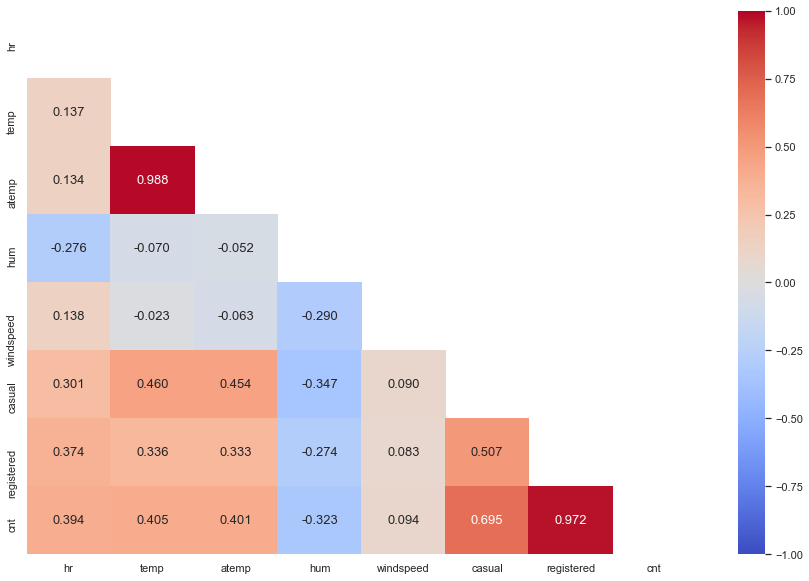

In [10]:
plt.figure(figsize=(15, 10))
sns.set(font_scale=1)
sns.set_style('white')

corr = df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool)) # Generating a mask for the upper triangle
sns.heatmap(corr, cmap='coolwarm',fmt='.3f', annot=True, mask=mask, annot_kws={'size':13}, vmin = -1, vmax = 1)
plt.show()

**Notes & Conclusions:**

* Count ("cnt") is our Y/target variable.
* "registered" and "casual" are the variables more correlated with "cnt" which is expected since the sum of both equal "cnt". These 2 variables will be dropped following instructions and also taking into consideration their relation with "cnt".
* "temp" & "atemp" are strongly correlated, which is also expected since they measure feeling temperature and temperature. We will drop the value with least explanatory power. They have around 40% correlation with "cnt.
* Humidity ("hum") is the only numerical variable with negative correlation with "cnt" with a value around -32% (blue color).

### 1.4. Giving insights on what seems relevant for prediction and what does not

By looking at the correlation heatmap above we already saw some variables with around 40% (excluding "casual" and "registered") which can show already some relevance for prediction. 

We could also check iteratively below the relation of each numerical variable with our target "cnt" in a scatter plot (which also includes our initially defined outliers from variable num1 represented in orange). A more detailed analysis of outliers will be made later.

 - "hr" we see clearly differences in bike rentals depending on the hour.
 - "windspeed" although showed the lowest correlation with "cnt" at around 9%, we can see if "windspeed" is above 0.6 there are almost no bike rentals.
 
In the next section we will perform feature engineering tranforming these initial variables and creating new ones, trying to extract more information and achieving higher relation with our target variable.

In [11]:
@ipw.interact(Column_Y = ipw.Dropdown(options = num_cols), Column_X = ipw.Dropdown(options = num_cols))
def out_graph(Column_Y, Column_X):
  lower, upper = outlier(df[Column_Y], 1.5)
  outliers = df[(df[Column_Y] > upper) | (df[Column_Y] < lower)]
  sns.scatterplot(x = df[Column_X], y = df[Column_Y])
  sns.scatterplot(x = outliers[Column_X], y = outliers[Column_Y])

interactive(children=(Dropdown(description='Column_Y', options=('hr', 'temp', 'atemp', 'hum', 'windspeed', 'ca…

## Part 2: Data Engineering

### 2.1. Discussion on missing values and outliers

Below we found 100 missing values in 4 variables and 99 missing values in 1 variable.

In [12]:
df.isna().sum()

dteday          0
hr              0
weathersit    100
temp           99
atemp         100
hum           100
windspeed     100
casual          0
registered      0
cnt             0
dtype: int64

**Examining the columns with missing values to see if there is any pattern.**

Showing 2 rows with missing values for each column and the general map.

In [13]:
df[df.weathersit.isna()].head(2)

,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,
329,2011-01-15,4,NaN,0.16,0.2273,0.59,0.0000,0,5,5
957,2011-02-12,11,NaN,0.30,0.2727,0.28,0.3284,30,84,114


In [14]:
df[df.temp.isna()].head(2)

,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,
56,2011-01-03,10,"Clear, Few clouds, Partly cloudy, Partly cloudy",NaN,0.1667,0.43,0.2537,11,33,44
134,2011-01-06,19,"Clear, Few clouds, Partly cloudy, Partly cloudy",NaN,0.2576,0.55,0.0896,3,109,112


In [15]:
df[df.atemp.isna()].head(2)

,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,
354,2011-01-16,5,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",0.26,NaN,0.56,0.1642,1,1,2
748,2011-02-03,13,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.20,NaN,0.40,0.4179,4,47,51


In [16]:
df[df.hum.isna()].head(2)

,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,
251,2011-01-11,19,"Light Snow, Light Rain + Thunderstorm + Scatte...",0.16,0.2273,NaN,0.0000,0,51,51
287,2011-01-13,9,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.14,0.1212,NaN,0.3284,2,137,139


In [17]:
df[df.windspeed.isna()].head(2)

,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,
55,2011-01-03,9,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.16,0.1364,0.43,NaN,7,81,88
278,2011-01-13,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.14,0.1212,0.59,NaN,1,6,7


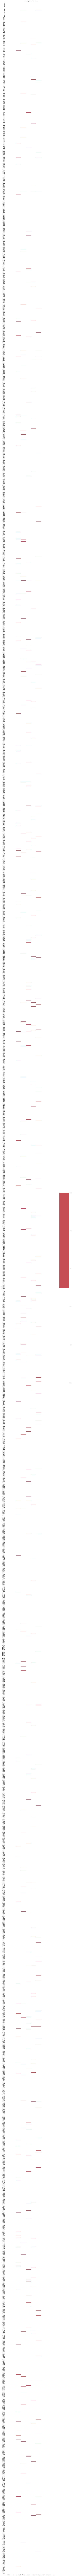

In [18]:
cols = df.columns 
colours = ['w', 'r'] 
f, ax = plt.subplots(figsize = (12,500))
sns.set_style("whitegrid")
plt.title('Missing Values Heatmap', )
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

If there's no discernable pattern causing the nulls, we know this is time series data therefore we can impute with the values of neighbours. Although there don't seem to be large gaps neither correlation between missing variables. Therefore we are using the method "forward fill" to propagate last valid observations forward.

In [19]:
df.fillna(method='ffill', inplace=True)

**Checking For Outliers.**

It’s often a good idea to detect outliers. Outliers can result in a less accurate model. We define a function to classificate as outliers in the beginning of our notebook (copied below) using the IQR technique (interquartile range). We will show the outliers visually and decide on removing them or not.

def outlier(col, n):

    IQR = col.quantile(.75) - col.quantile(.25)
    
    upper = col.quantile(.75) + (n*IQR)
    
    lower = col.quantile(.25) - (n*IQR)
    
    print("Percent Outliers:", "{:.2%}".format( ( len(df[col > upper]) + len(df[col < lower]) ) / len(df) ) )
    
    print("Percent Low Outliers:", "{:.2%}".format( len(df[col < lower]) / len(df) ) )
    
    print("Percent High Outliers:", "{:.2%}".format( len(df[col > upper]) / len(df) ) )
    
    return lower, upper

For each column we had a look at the Box Plot, Histogram and Scatter Plot with our index variable "instant". Below our conclusions on outliers (calculated with the previous function):

***Windspeed column***

Below we can see we have a few high "outliers", but overall they make up only 1.97% of the dataset. These seem like natural expected features within the dataset, and it makes sense that windspeed is normally mild but might be much higher during bad weather. On manual inspection data does not seem abnormal. Instances of high outliers are physically close to eachother in time, which makes sense given high windspeed (like a gust) will continue for a few seconds before subsiding. Does not appear to be sensor error, because in that case if we plot these values over time we would expect to see them clustered together.

***Casual column***

These outliers also seem like a natural feature of the data - casual users seem to spike during certain periods which might be explained by larger groups of casual riders renting bikes in groups.

***Registered column***

Again, because this is timeseries data we would expect outliers to cluster together over time. Below we can see the distribution of what might be considered an "outlier" solely due to distribution, and these values seem like a natural part of the dataset and not a measurement error. In this case, it seems like the number of registered is increasing over time which likely speaks to an increasing popularity for the bike rentals (and more regular users as a result).

***Cnt column***

Similar distribution of outliers as "registered" column and the same conclusions can be applied.

In [20]:
@ipw.interact(column_name = ipw.Dropdown(options = num_cols))
def out_graph(column_name):
      sns.boxplot(x = df[column_name])
      lower, upper = outlier(df[column_name], 1.5)
    
@ipw.interact(Column = ipw.Dropdown(options = num_cols))
def plot_hist(Column):
  sns.distplot(a = df[Column], kde=True)

df.reset_index(inplace=True)
@ipw.interact(Column_Y = ipw.Dropdown(options = num_cols))
def out_graph(Column_Y):
      lower, upper = outlier(df[Column_Y], 1.5)
      outliers = df[(df[Column_Y] > upper) | (df[Column_Y] < lower)]
      sns.scatterplot(x = df["instant"], y = df[Column_Y])
      sns.scatterplot(x = outliers["instant"], y = outliers[Column_Y])

interactive(children=(Dropdown(description='column_name', options=('hr', 'temp', 'atemp', 'hum', 'windspeed', …

interactive(children=(Dropdown(description='Column', options=('hr', 'temp', 'atemp', 'hum', 'windspeed', 'casu…

interactive(children=(Dropdown(description='Column_Y', options=('hr', 'temp', 'atemp', 'hum', 'windspeed', 'ca…

In [21]:
df = df.set_index("instant")

### 2.2. Treatment of text and date features


#### Weather situation treatment

The only text variable we have is "weathersit". We will divide it into 2 different categories: good weather and bad weather.

We see it was good weather in around 92% of the observations. Later this variable will be transformed in a binary variable (0,1) for modelling purposes.

In both graphs, we find that the distribution of our observations depending on the weather conditions and we see that the number of bikes rented when there is "bad" weather is lower than when the weather is considered "good".

              Counts  Percentage (%)
Good Weather   15950           91.78
Bad Weather     1429            8.22


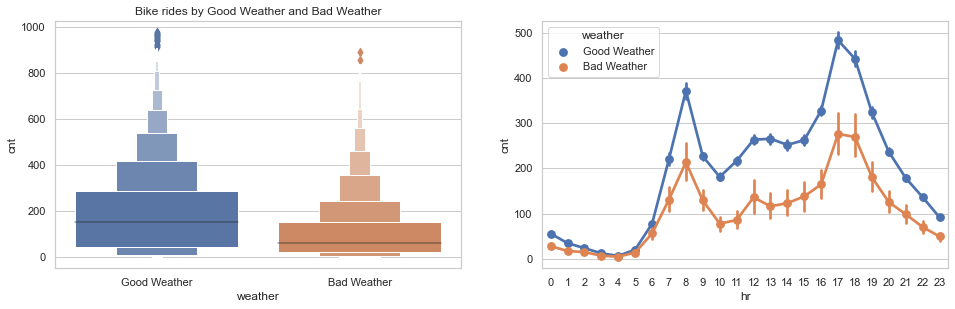

In [22]:
bad_weather = ['Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
               'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog'
              ]

df['weather'] = ["Bad Weather" if x in bad_weather else "Good Weather" for x in df.weathersit.values]

value = df['weather'].value_counts()
percent = round(df['weather'].value_counts(normalize = True) * 100,2)
print(pd.concat([value, percent], axis = 1, keys=['Counts', 'Percentage (%)']))
fig, axes = plt.subplots(1,1,figsize = (16, 10))

ax12 = plt.subplot(2,2,1)
sns.boxenplot(data = df, x='weather',y='cnt')
plt.title('Bike rides by Good Weather and Bad Weather');

ax11 = plt.subplot(2,2,2)
ax = sns.pointplot(x=df['hr'] , y=df['cnt'] , hue = df['weather'])



#### Date treatment

The column that we have for the date is datetime type. From this variable we will extract 5 new variables: the year, the month, the day, the day of the week and the day of the year.



The differences observed in "dayofweek" graph will give origin of our next new variable "workday".

The 1st graph shows the distribution by hour depending on the year. Year 2012 is represented by the orange line and 2011 by the blue one. They follow a very similar distribution if we filter by hour and count, but the number of bikes rented, clearly increased in 2012.

The 2nd graph shows the number of bikes rented by hour and also by day of the week. We find a very similar distribution in all the days of the week from Monday to Friday(0-5) and a very similiar distribution during the weekends (6 and 7). We can observe different time frames depending if is weekday or weekend, that is why we will dive deeper and will take a better look at it, plotting a new graph depending if is weekend or not after the creation of a new variable "workday" which will also include holidays.

Text(0.5, 1.0, 'Graph 2: The influence of hour (dayofweek)')

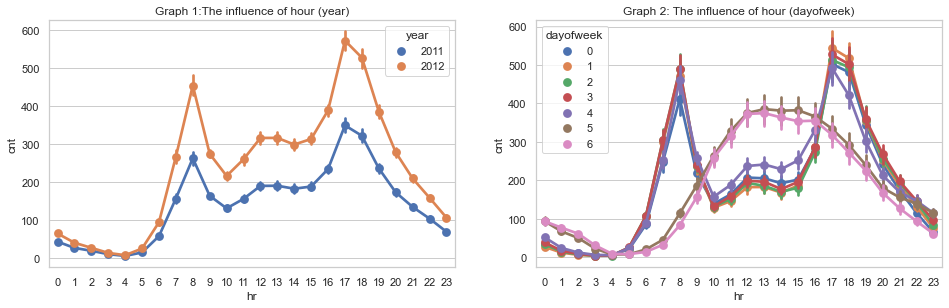

In [23]:
df["year"] = df.dteday.dt.year
df["month"] = df.dteday.dt.month
df["day"] = df.dteday.dt.day
df["dayofweek"] = df.dteday.dt.dayofweek #to know working day or not: monday(0)-friday(4)
df["dayofyear"]= df.dteday.dt.dayofyear

fig, axes = plt.subplots(1,1,figsize = (16, 10))
ax11 = plt.subplot(2,2,1)
sns.pointplot(x=df['hr'] , y=df['cnt'] , hue = df['year'] , ax = ax11)
ax11.set_title('Graph 1:The influence of hour (year)')

ax12 = plt.subplot(2,2,2)
sns.pointplot(x=df['hr'] , y=df['cnt'] , hue = df['dayofweek'] , ax = ax12)
ax12.set_title('Graph 2: The influence of hour (dayofweek)')

As we already know, the total number of usered are divided in two categories: registered and casual users.

We created a barplot to see the registered users and another one with casual users per day of the week.

We notice how Saturday and Sundays are the days in which we have less registered users. This makes sense as there are many registered users that take the bike to work.

When we look at the casual users, we observe the opposite. We can slightly start to see the increase on Friday but the number of casual users is much higher during the weekends than during the weekdays. People that rent during the weekends probably do it more as a hobbie instead of as a routine.

Text(0.5, 1.0, 'The influence of day of the week (Casual Users)')

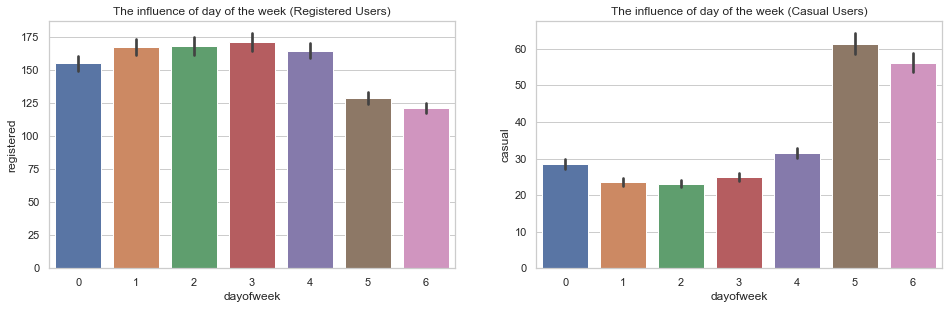

In [24]:
fig, axes = plt.subplots(1,1,figsize = (16, 10))
ax11 = plt.subplot(2,2,1)
sns.barplot(df.dayofweek,df.registered, ax = ax11)
ax11.set_title('The influence of day of the week (Registered Users)')

ax12 = plt.subplot(2,2,2)
sns.barplot(df.dayofweek,df.casual, ax = ax12)
ax12.set_title('The influence of day of the week (Casual Users)')

### 2.3. Generation of extra features and studying the influence of combinations of features

#### Holidays and workday variables

Our next new variables are "holidays" created manually and "workday" created from a combination of the previously created "dayofweek" and "holidays".

We mentioned above that there are different time frames that we can find depending of wether is a weekday or non workay (weekend and holidays). These are the most important low and high peaks:

   - 0-6h (workdays and non workdays): The number of bikes rentals at this time is very low.

   - 7-9h, especially at 8h and 18-19h (weekdays): clearly increase on the "cnt". These are the usual commute times, there might be many users taking the bike to work or back home after work.

   - 12-19h (non work days): this is where we find the highest number of rentals. It seems like people like to take the bike during the evenings.

   - 19-23 (workdays and non workdays): We see a big decrease in the number of rentals around 19h, probably when it starts getting darker outside.

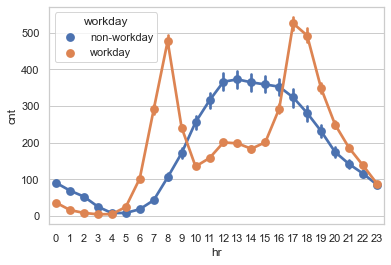

In [25]:
# source for holidays 2011 and 2012:
#https://dchr.dc.gov/page/holiday-schedules-2010-and-2011 and https://dchr.dc.gov/page/holiday-schedules-2012-and-2013

holidays =  ["2011-01-17", # Martin Luther King Jr. Day
            "2011-02-21", # Washington's Birthday
             "2011-04-15", # DC Emancipation Day
             "2011-05-30", # Memorial Day
            "2011-07-04", # Independence Day
            "2011-09-05", # Labor Day
            "2011-10-10", # Columbus Day
             "2011-11-11", # Veterans Day
             "2011-10-10", # Columbus Day
             "2011-11-24", # Thanksgiving Day
             "2011-12-26", # Christmas Day

            "2012-01-02", # New Year's Day  
             "2012-01-16", # Martin Luther King Jr. Day
            "2012-02-20", # Washington's Birthday
             "2012-04-16", # DC Emancipation Day
             "2012-05-28", # Memorial Day
            "2012-07-04", # Independence Day
            "2012-09-03", # Labor Day
            "2012-10-08", # Columbus Day
             "2012-11-12", # Veterans Day
             "2012-11-22", # Thanksgiving Day
             "2012-12-25"] # Christmas Day
holidays = pd.to_datetime(holidays) # to date time 
    
conditions = [
    (df['dayofweek'].isin([1,2,3,4,0])) & (~df['dteday'].isin(holidays) ),  # Workdays = weekdays if not holiday
    (df['dayofweek'].isin([5,6]) | (df['dteday'].isin(holidays)) ) # Weekend or holidays
    ]
values = ["workday","non-workday"]
#create a new column and use np.select to assign values to it using our lists as arguments
df['workday'] = np.select(conditions, values)

ax = sns.pointplot(x=df['hr'] , y=df['cnt'] , hue = df['workday'])

#### Season variable

Our next new variable is "season" extracted from the previously created "dayofyear". We looked to see the exact dates of the season for 2011 and 2012 to separate the days of the year per season.

It seems to be a high correlation with the "cnt" and the seasonality as the better the weather is depending on the season of the year, the higher the number of rentals. Summer, fall and spring, following this order, have a very similar number of bike rentals per season, but we can see that as it gets later in the evening the "cnt" for summer during these hours is considerably higher than in the fall and spring. On the other hand, we see an important decrease during all hours during the winter.

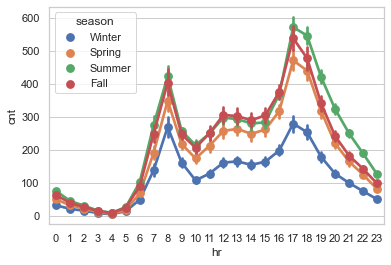

In [26]:
conditions = [
    (df['dayofyear'] >= 61) & (df['dayofyear'] <= 150), #spring = range(61, 150)   #1
    (df['dayofyear'] >= 151) & (df['dayofyear'] <= 240), #summer = range(151, 240)   # 2
    (df['dayofyear'] >= 241) & (df['dayofyear'] <= 330), #fall = range(241, 330)     #3
    (df['dayofyear'] >= 331) |  (df['dayofyear'] <= 60) # winter = everything else   #4
    ]

#source for seasons:
#https://travel.usnews.com/Washington_DC/When_To_Visit/#:~:text=The%20best%20times%20to%20visit,of%20the%20high%20season%20tourists.

#create a list of the values we want to assign for each condition
values = ["Spring", "Summer", "Fall", "Winter"]
#create a new column and use np.select to assign values to it using our lists as arguments
df['season'] = np.select(conditions, values)

ax = sns.pointplot(x=df['hr'] , y=df['cnt'] , hue = df['season'])

#### Timeofday variable

Finally we will create a new variable called "Timeofday" by dividing the "hr" variable in 6 different ranges corresponding to 6 parts of the day.

We are looking at something similar to what we did above plotting the total count by hour and depending on wether it was weekday or not. We will be filtering by time of the day in this case. We created six variables based on the time of the day:

   - Early morning (from 6am-9am)
   - Morning (10am-12pm)
   - Lunch time (1pm-3pm)
   - Early evening (4pm-7pm)
   - Late evening (8pm-9pm)
   - Night (10pm-12am)
   - Late night (12am-6am)

In regards to the new variable "timeofday" it captures the same variations as by hour, but with less dimensions.

The number of bike rentals start increasing in the early morning, having morning, lunch time and early evening the highest total count. It starts decreasing on the late evening.
In regards to the seasonality, we already discussed that summer has the highest total count, closely followed by fall and spring and then we see a big difference in the winter with a much lower number in the total count.
We also mentioned the times where the total number of count is higher depending on the days of the week. For the weekdays, early morning, end of the evening and beginning of late evening is where we have the highest peaks. For the non work days, the highest peaks are during lunch time and early evening.
In which concerns the weather conditions, we find that it follows the same pattern that we have just mentioned in these previous ones.

In [27]:
conditions = [
    (df['hr'].isin([7,8,9])),  #early morning
    (df['hr'].isin([10,11,12])),  #morning
    (df['hr'].isin([13, 14, 15])), #lucnh time, 
    (df['hr'].isin([16, 17, 18, 19])), # early evening
    (df['hr'].isin([20, 21])),  # late evening
    (df['hr'].isin([22, 23,0])), # night
    (df['hr'].isin([1,2,3,4,5,6])), #late_night
     ]
values = ["early_morning", "morning","lucnh time","early evening","late evening","night", "late_night"]
df['time_of_day'] = np.select(conditions, values)

Text(0.5, 1.0, 'The influence of time of day (weather)')

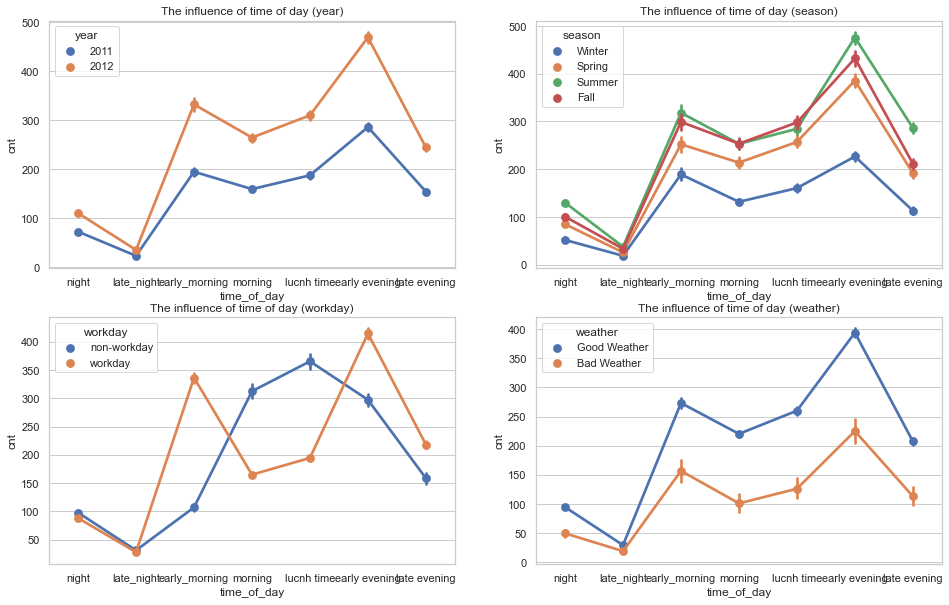

In [28]:
fig, axes = plt.subplots(2,2,figsize = (16, 10))
ax11 = plt.subplot(2,2,1)
sns.pointplot(x=df['time_of_day'] , y=df['cnt'] , hue = df['year'] , ax = ax11)
ax11.set_title('The influence of time of day (year)')

ax12 = plt.subplot(2,2,2)
sns.pointplot(x=df['time_of_day'] , y=df['cnt'] , hue = df['season'] , ax = ax12)
ax12.set_title('The influence of time of day (season)')

ax2 = plt.subplot(2,2,3)
sns.pointplot(x=df['time_of_day'] , y=df['cnt'] , hue = df['workday'] , ax = ax2)
ax2.set_title('The influence of time of day (workday)')

ax3 = plt.subplot(2,2,4)
sns.pointplot(x=df['time_of_day'] , y=df['cnt'] , hue = df['weather'] , ax = ax3)
ax3.set_title('The influence of time of day (weather)')

### 2.4. Giving new insights on what seems relevant for prediction and what does not

After seing the visializations of our new categories and the effect they have in our target when combining different variables, we will create a new dataframe with all the variables transformed into numeric just to observe the new correlation matrix with all variables.

Conclusions:
   - We can see as expected high correlation between "dayofyear" and "month" and between "dayofweek" and "workday". Only month and worked will be used in the model from these 4 variables as they correlate more with our target than the other 2 variables.
   - From the reamining new variables only "day" will not be used in the model since it shows no relevance.

<ipython-input-29-1a41091a84bc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric["weather"] = df["weather"].astype('category').cat.codes
<ipython-input-29-1a41091a84bc>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric["workday"] = df["workday"].astype('category').cat.codes
<ipython-input-29-1a41091a84bc>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

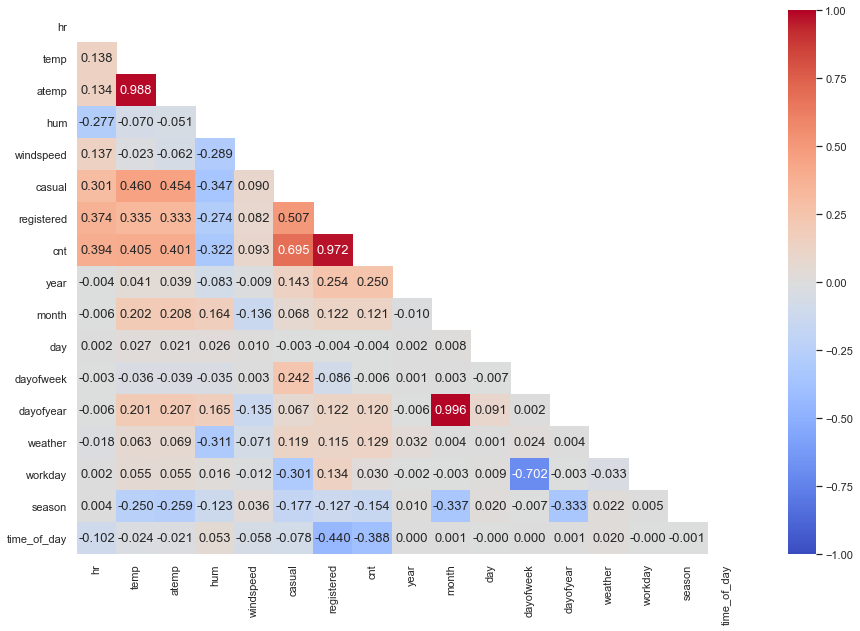

In [29]:
df_numeric = pd.DataFrame(dtype=np.int8)

numeric_from_df = df.select_dtypes(include=np.number).columns.to_list()
df_numeric =df[numeric_from_df]
df_numeric["weather"] = df["weather"].astype('category').cat.codes
df_numeric["workday"] = df["workday"].astype('category').cat.codes
df_numeric["season"] = df["season"].astype('category').cat.codes
df_numeric["time_of_day"] = df["time_of_day"].astype('category').cat.codes

plt.figure(figsize=(15, 10))
sns.set(font_scale=1)
sns.set_style('white')

corr = df_numeric.corr()

mask = np.triu(np.ones_like(corr, dtype=bool)) # Generating a mask for the upper triangle
sns.heatmap(corr, cmap='coolwarm',fmt='.3f', annot=True, mask=mask, annot_kws={'size':13}, vmin = -1, vmax = 1)
plt.show()

### 2.5. Use of scikit-learn pipelines to perform transformations

**Preprocessing Pipeline:**

Since we have already fill in the missing values, our pipeline will be responsabile for creating a binary column for each category in our categorical variables using "OneHotEncoder".

In [30]:
base_processing = ColumnTransformer([
                                        
                                     ("transform_categorical", Pipeline([
                                          ("encode", OneHotEncoder(handle_unknown="ignore"))
                                     ]), make_column_selector(dtype_exclude = np.number)),
    
                                  ], remainder = "passthrough")

base_processing

ColumnTransformer(remainder='passthrough',
                  transformers=[('transform_categorical',
                                 Pipeline(steps=[('encode',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000220FC6EE700>)])

## Part 3: Machine Learning 

**Requirements:**
   * **Training data:** whole 2011 and first 3 quarters of 2012.
   * **Test data:** 4th quarter of 2012. Do not use it to fit your models!
   * **Target:** total number of users (cnt)
   * **Error metric:** R2 score (scikit-learn's default for regression).
   * **Features to use:** at least the ones present in the data (except for cnt, casual, and registered).
   
After dividing our dataframe in Train and Test following the instructions, we have 15211 rows to train and 2168 to test.

In [31]:
train = df[df.dteday < "2012-10-01"]
test = df[df.dteday >= "2012-10-01"]

#train dataset
X_train = train.drop(columns = ["cnt", "casual", "registered"])
y_train = train["cnt"]

#test dataset
X_test = test.drop(columns = ["cnt", "casual", "registered"])
y_test = test["cnt"]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape )
print(y_test.shape)

X_train.info()

(15211, 16)
(15211,)
(2168, 16)
(2168,)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 15211 entries, 1 to 15211
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   dteday       15211 non-null  datetime64[ns]
 1   hr           15211 non-null  int64         
 2   weathersit   15211 non-null  object        
 3   temp         15211 non-null  float64       
 4   atemp        15211 non-null  float64       
 5   hum          15211 non-null  float64       
 6   windspeed    15211 non-null  float64       
 7   weather      15211 non-null  object        
 8   year         15211 non-null  int64         
 9   month        15211 non-null  int64         
 10  day          15211 non-null  int64         
 11  dayofweek    15211 non-null  int64         
 12  dayofyear    15211 non-null  int64         
 13  workday      15211 non-null  object        
 14  season       15211 non-null  object        
 15  time_of_day  

### 3.1. Choosing sensible models (linear and non-linear)

### 3.1. a) Baseline Linear Regression with Initial Variables

We start with a simple linear regression model only with 6 initial variables (named "parameters") to have it as benchmark. From the initial variables only "atemp" (due to the already mentioned high correlation with "temp") is not included. We took into consideration the requirements saying the features to use were at least the ones present in the data (except for cnt, casual, and registered). Later new features will be added. 

To evaluate the models we will use the initially defined function "evaluate" which computes 3 different measures:

def mean_absolute_percentage_error(y_true, y_pred):

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate(test_features, test_labels):

    print('Root Mean squared error: %.2f'% mean_squared_error(test_features, test_labels,squared = False))
    
    print('Coefficient of determination: %.2f'%r2_score(test_features, test_labels))
    
    print('MAPE: %.2f'%  mean_absolute_percentage_error(test_features, test_labels))

In [32]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15211 entries, 1 to 15211
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   dteday       15211 non-null  datetime64[ns]
 1   hr           15211 non-null  int64         
 2   weathersit   15211 non-null  object        
 3   temp         15211 non-null  float64       
 4   atemp        15211 non-null  float64       
 5   hum          15211 non-null  float64       
 6   windspeed    15211 non-null  float64       
 7   weather      15211 non-null  object        
 8   year         15211 non-null  int64         
 9   month        15211 non-null  int64         
 10  day          15211 non-null  int64         
 11  dayofweek    15211 non-null  int64         
 12  dayofyear    15211 non-null  int64         
 13  workday      15211 non-null  object        
 14  season       15211 non-null  object        
 15  time_of_day  15211 non-null  object        
dtypes: d

Root Mean Squared Error: 129.43
Coefficient of determination: 0.47
MAPE: 306.08


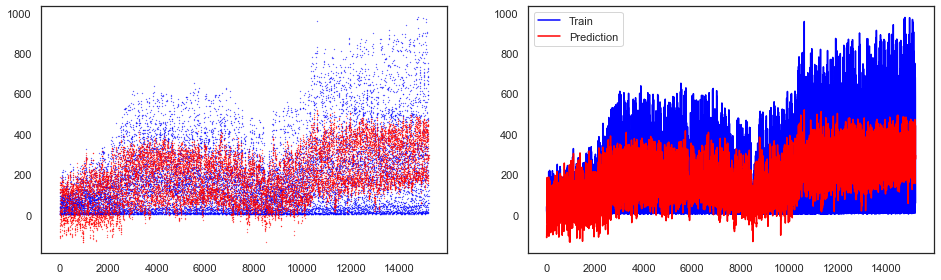

In [33]:
parameters = ['dteday', 'hr', 'weathersit', 'temp', 'hum', 'windspeed'] # variables to include in the model

X_train = train[parameters] 

model = Pipeline([
                ("Preprocessing", base_processing),
                ("Engine", LinearRegression())
                ])

#Fit Model:
lm_model = model.fit(X = X_train, y = y_train)

#Predict:
y_hat_train = lm_model.predict(X_train)

#custom function 
evaluate(y_train, y_hat_train)

#Plot Outputs:
fig, axes = plt.subplots(1,1,figsize = (16, 10))
ax11 = plt.subplot(2,2,1)
plt.scatter(X_train.index, y_train,  color='blue', s=5/72)
plt.scatter(X_train.index, y_hat_train, color='red', s = 5/72)
ax12 = plt.subplot(2,2,2)
pd.Series(y_train.to_numpy()).plot(ax =ax12 , label = "Train", color = 'blue')
pd.Series(y_hat_train).plot(ax =ax12 , label = "Prediction",  color='red')
legend = ax12.legend(loc='upper left')

### Confirming the model pipeline.

In [34]:
model

Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('transform_categorical',
                                                  Pipeline(steps=[('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000220FC6EE700>)])),
                ('Engine', LinearRegression())])

### Evaluating the model in the test dataset. 

Below we can see our predictions are not accurate in the test dataset in comparisson to the actual target values. We can see the deviation of the actual and prediction by looking at the two graphs and also the computed metrics. In order to improve our predictions we must either change our predictor variables, model paramaters or the type of model.

Root Mean Squared Error: 204.51
Coefficient of determination: -0.03
MAPE: 219.19


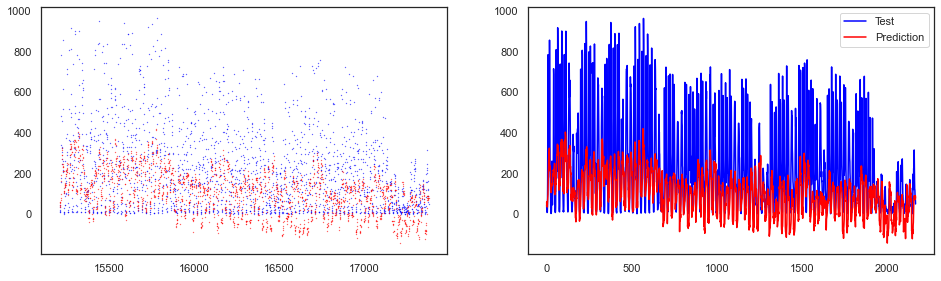

In [35]:
X_test = test[parameters] # same variables as trained model

#Predict
y_hat_test = lm_model.predict(X_test)

#Metrics:
evaluate(y_test,y_hat_test)

#Plot Outputs:
fig, axes = plt.subplots(1,1,figsize = (16, 10))
ax11 = plt.subplot(2,2,1)
plt.scatter(X_test.index, y_test,  color='blue', s=5/72)
plt.scatter(X_test.index, y_hat_test, color='red', s = 5/72)
ax12 = plt.subplot(2,2,2)
pd.Series(y_test.to_numpy()).plot(ax =ax12 , label = "Test", color = 'blue')
pd.Series(y_hat_test).plot(ax =ax12 , label = "Prediction",  color='red')
legend = ax12.legend(loc='upper right')

### 3.1. b) Linear Regression with New Variables

We will now add 6 of the new variables we created to the parameters list (as explained in the previous section in the second correlation analysis) and exclude 2 variables "dteday" and "weather_sit" since new variables were created from that information. We will run again a regression model with the same sequence to see if it improves, mainly in the test dataset.

Root Mean Squared Error: 107.26
Coefficient of determination: 0.64
MAPE: 283.69


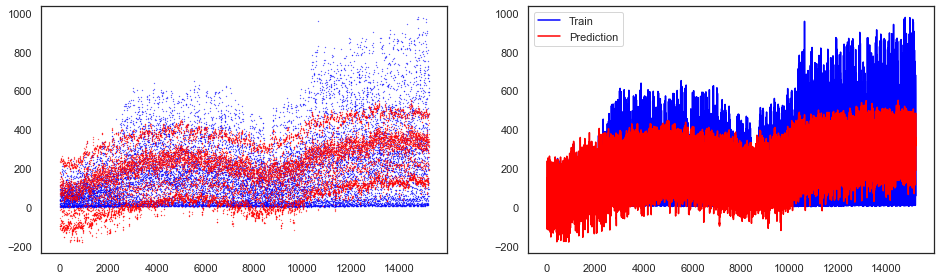

In [36]:
#Fit Model:
parameters = ['hr',"temp","hum","windspeed","weather","year","month", "workday","season","time_of_day"]

X_train = train[parameters]

lm_model_2 = model.fit(X = X_train, y = y_train)

#Predict:
y_hat_train = lm_model.predict(X_train)

#custom function 
evaluate(y_train, y_hat_train)

#Plot Outputs:
fig, axes = plt.subplots(1,1,figsize = (16, 10))
ax11 = plt.subplot(2,2,1)
plt.scatter(X_train.index, y_train,  color='blue', s=5/72)
plt.scatter(X_train.index, y_hat_train, color='red', s = 5/72)
ax12 = plt.subplot(2,2,2)
pd.Series(y_train.to_numpy()).plot(ax =ax12 , label = "Train", color = 'blue')
pd.Series(y_hat_train).plot(ax =ax12 , label = "Prediction",  color='red')
legend = ax12.legend(loc='upper left')

### Evaluating the model in the test dataset.

Root Mean Squared Error: 133.95
Coefficient of determination: 0.56
MAPE: 260.26


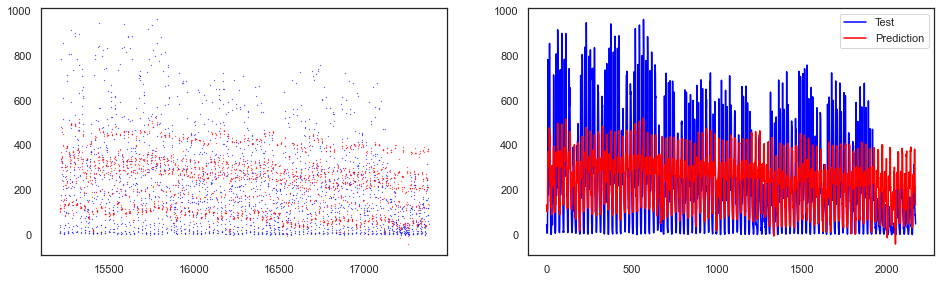

In [37]:
X_test = test[parameters]

#Predict
y_hat_test = lm_model_2.predict(X_test)

#Metrics:
evaluate(y_test,y_hat_test)

#Plot Outputs:
fig, axes = plt.subplots(1,1,figsize = (16, 10))
ax11 = plt.subplot(2,2,1)
plt.scatter(X_test.index, y_test,  color='blue', s=5/72)
plt.scatter(X_test.index, y_hat_test, color='red', s = 5/72)
ax12 = plt.subplot(2,2,2)
pd.Series(y_test.to_numpy()).plot(ax =ax12 , label = "Test", color = 'blue')
pd.Series(y_hat_test).plot(ax =ax12 , label = "Prediction",  color='red')
legend = ax12.legend(loc='upper right')

We can see above that both the train and the test metrics improved compared with the baseline model, being the improvement in the test metrics even of higher magnitude than the train metrics. We are happy that our new variables improved the model, but still we have seen the data does not follow a linear trend so we will now look for a non-liner model using the same variables.

### 3.1. c) Baseline Random Forrest

Our data has a non-linear shape and the linear model cannot capture the non-linear features. Therefore we will now implemenrt a Random Forest (non-linear) model using the same 10 variables used in the last linear regression model.

Random forest is a type of supervised machine learning algorithm based on ensemble learning, which is a type of learning where are joined different types of algorithms or same algorithm multiple times to form a more powerful prediction model. The random forest algorithm combines multiple algorithm of the same type i.e. multiple decision trees, resulting in a forest of trees, hence the name "Random Forest". The random forest algorithm can be used for both regression and classification tasks.

We will be using the default paramaters of Random Forest as a benchmark to compare hyperparameter tuning and feature selections for the succeding Random Forest models. 

Root Mean Squared Error: 16.63
Coefficient of determination: 0.99
MAPE: 12.52


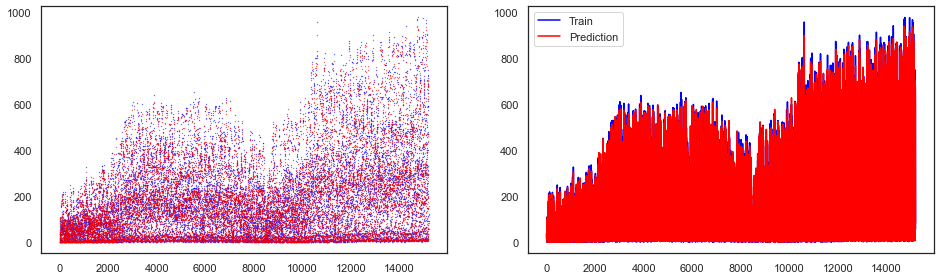

In [38]:
model = Pipeline([
                ("Preprocessing", base_processing),
                ("Engine", RandomForestRegressor( n_jobs = -1, random_state = 42))
                ])

#Transform Data:
base_processing.fit_transform(X = X_train)


#Fit Model:
RF_model = model.fit(X = X_train, y = y_train)

#Predict:
y_hat_train = RF_model.predict(X_train)


#custom function 
evaluate(y_train, y_hat_train)

#Plot Outputs:
fig, axes = plt.subplots(1,1,figsize = (16, 10))
ax11 = plt.subplot(2,2,1)
plt.scatter(X_train.index, y_train,  color='blue', s=5/72)
plt.scatter(X_train.index, y_hat_train, color='red', s = 5/72)
ax12 = plt.subplot(2,2,2)
pd.Series(y_train.to_numpy()).plot(ax =ax12 , label = "Train", color = 'blue')
pd.Series(y_hat_train).plot(ax =ax12 , label = "Prediction",  color='red')
legend = ax12.legend(loc='upper left')

### Confirming the model pipeline.

In [39]:
model

Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('transform_categorical',
                                                  Pipeline(steps=[('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000220FC6EE700>)])),
                ('Engine', RandomForestRegressor(n_jobs=-1, random_state=42))])

### Evaluating the model in the test dataset.

Root Mean Squared Error: 77.97
Coefficient of determination: 0.85
MAPE: 47.18


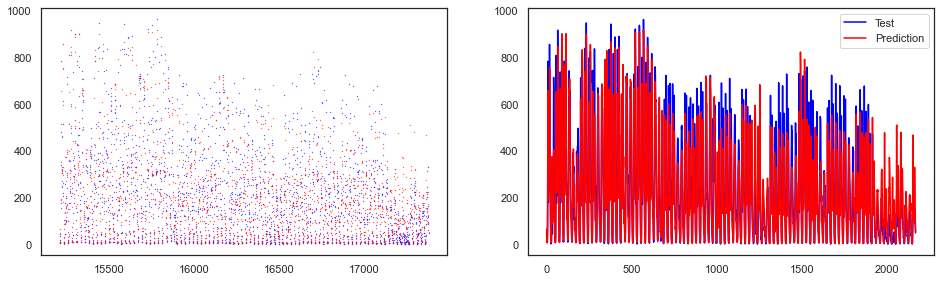

In [40]:
#Predict:
y_hat_test = RF_model.predict(X_test)

#custom function 
evaluate(y_test, y_hat_test)

#Plot Outputs:
fig, axes = plt.subplots(1,1,figsize = (16, 10))
ax11 = plt.subplot(2,2,1)
plt.scatter(X_test.index, y_test,  color='blue', s=5/72)
plt.scatter(X_test.index, y_hat_test, color='red', s = 5/72)
ax12 = plt.subplot(2,2,2)
pd.Series(y_test.to_numpy()).plot(ax =ax12 , label = "Test", color = 'blue')
pd.Series(y_hat_test).plot(ax =ax12 , label = "Prediction",  color='red')
legend = ax12.legend(loc='upper right')

As expected, we can see that our baseline Random Forest model did not do as well in the test dataset as in the train dataset. However, it has outperformed both linear regression models. 

### 3.2. Tuning model parameters with validation

Using "grid_search" to find the best compbinations of parameters for the Random Forest Model.

Random forest important paramaters:

 - bootstrap = method for sampling data points (with or without replacement)
 - max_depth = max number of levels in each decision tree
 - min_samples_leaf = min number of data points allowed in a leaf node
 - min_samples_split = min number of data points placed in a node before the node is split
 - n_estimators - number of trees in the foreset
 - max_features = max number of features considered for splitting a node
 
For the purpose of this experiment we limit our model to five parameters. As we have limited amount of time and limited amount of processing power, we would like to choose those paramaters that will prevent overfitting.  

In [41]:
# Create the parameter grid based on the results of random search 
rf_param_grid = {
    'bootstrap': [True], 
    'max_depth': [10, 20, 30],
    'min_samples_leaf' : [1, 2, 3],
    'min_samples_split' : [8, 10, 12],
    'n_estimators': [5, 6, 7, 8, 9, 10] 
}

# Create a based model
rf = RandomForestRegressor(random_state = 42, n_jobs = -1)

# Instantiate the grid search model
grid_search = GridSearchCV( estimator = rf, param_grid = rf_param_grid ,cv = 3, n_jobs = -1)

grid_search.fit(base_processing.fit_transform(X_train), y_train)

grid_search.best_params_

{'bootstrap': True,
 'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'n_estimators': 6}

### 3.3. Obtaining accurate predictions in test

We will run again the Random Forest model, now with the best parameters previously selected by the cross validation. We will see the results very similar to the previous Random Forest model.

In [42]:
model_best_rf = Pipeline([
                ("Preprocessing", base_processing),
                ("Engine", RandomForestRegressor(n_jobs = -1, random_state = 42, 
    bootstrap= True , 
    max_depth =  20,
    min_samples_leaf = 1,
    min_samples_split =  8,
    n_estimators =  6))
                ])

#Fit Model:
RF_model_1 = model_best_rf.fit(X = X_train, y = y_train)

#Predict:
y_hat_test = RF_model_1.predict(X_test)


#custom function 
evaluate(y_test, y_hat_test)

Root Mean Squared Error: 79.67
Coefficient of determination: 0.84
MAPE: 47.45


We can see below the reason for the similar result. By adding more trees to our Random Forrest decreases the error measures in a marginally less of an effect on our train dataset (as expected) but does not affect our predictions for the test dataset.

N_trees: 1, rmse_train: 37.919, rmse_test=79.671
N_trees: 6, rmse_train: 21.118, rmse_test=79.671
N_trees: 11, rmse_train: 19.049, rmse_test=79.671
N_trees: 16, rmse_train: 18.165, rmse_test=79.671
N_trees: 21, rmse_train: 17.739, rmse_test=79.671
N_trees: 26, rmse_train: 17.421, rmse_test=79.671
N_trees: 31, rmse_train: 17.254, rmse_test=79.671
N_trees: 36, rmse_train: 17.165, rmse_test=79.671
N_trees: 41, rmse_train: 17.106, rmse_test=79.671
N_trees: 46, rmse_train: 16.974, rmse_test=79.671
N_trees: 51, rmse_train: 16.927, rmse_test=79.671
N_trees: 56, rmse_train: 16.832, rmse_test=79.671
N_trees: 61, rmse_train: 16.803, rmse_test=79.671
N_trees: 66, rmse_train: 16.779, rmse_test=79.671
N_trees: 71, rmse_train: 16.765, rmse_test=79.671


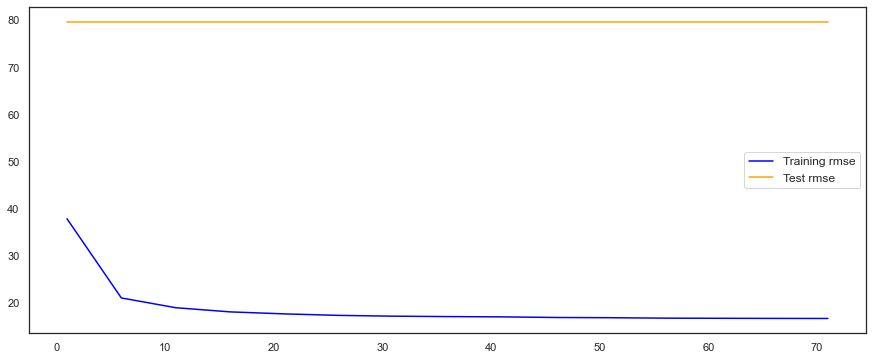

In [43]:
trees_range = range(1, 75, 5)

error_results = []

# looping through values of max_depth
for i, trees in enumerate(trees_range):
    
    # train
    rf = Pipeline([
                ("Preprocessing", base_processing),
                ("Engine", RandomForestRegressor(n_estimators=trees, random_state= 42 , n_jobs = -1))
                ])
    rf.fit(X_train, y_train)
    
    # predict
    y_hat_train = rf.predict(X_train)
      
        
    # evaluate
    rmse_train = mean_squared_error(y_train, y_hat_train,squared = False)
    rmse_test = mean_squared_error(y_test, y_hat_test,squared = False)
    
    # store results
    error_results.append({
        "n_trees": trees, 
        "rmse_train": rmse_train,
        "rmse_test": rmse_test
    })
    
    # print evolution of loop:
    print(f"N_trees: {trees}, rmse_train: {rmse_train:.3f}, rmse_test={rmse_test:.3f}")
    
# saving results as dataframe
results = pd.DataFrame(error_results)

# plotting
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(results["n_trees"], results["rmse_train"], label="Training rmse", color="blue")
ax.plot(results["n_trees"], results["rmse_test"], label="Test rmse", color="orange")
ax.legend(fontsize=12)

plt.show()

### 3.4. Plotting predictions vs reality for additional insights

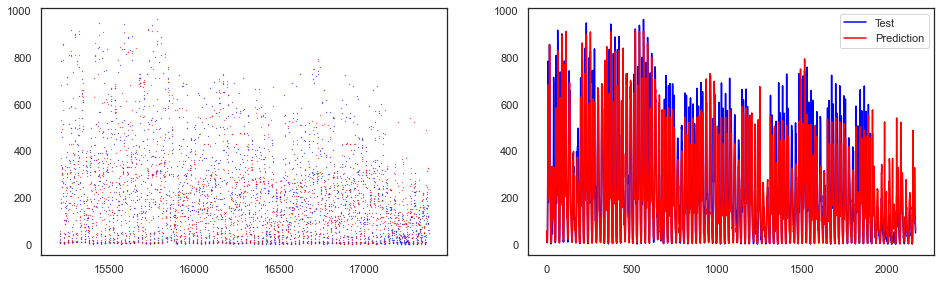

In [44]:
#Plot Outputs:
fig, axes = plt.subplots(1,1,figsize = (16, 10))
ax11 = plt.subplot(2,2,1)
plt.scatter(X_test.index, y_test,  color='blue', s=5/72)
plt.scatter(X_test.index, y_hat_test, color='red', s = 5/72)
ax12 = plt.subplot(2,2,2)
pd.Series(y_test.to_numpy()).plot(ax =ax12 , label = "Test", color = 'blue')
pd.Series(y_hat_test).plot(ax =ax12 , label = "Prediction",  color='red')
legend = ax12.legend(loc='upper right')

### Final insights

Previously, the linear regression model showed an improvement with the inclusion of the new variables we created in our feature engineering section after a deep analysis of the data. 

Finally, our 2 Random Forest models, before tuning parameters and after tuning parameters, showed a coefficient of determination of 0.85 and 0.84 respectively in the test dataset and a root mean squared error of 77.97 and 79.67 respectively in the test dataset. Therefore, also by looking at the plots above, we are happy to say our variables and our models were able to do a good prediction of our target variable.